<a href="https://colab.research.google.com/github/RonnyGuevara/Digital-image-processing/blob/main/TP_FINAL/TP_FINAL_PDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

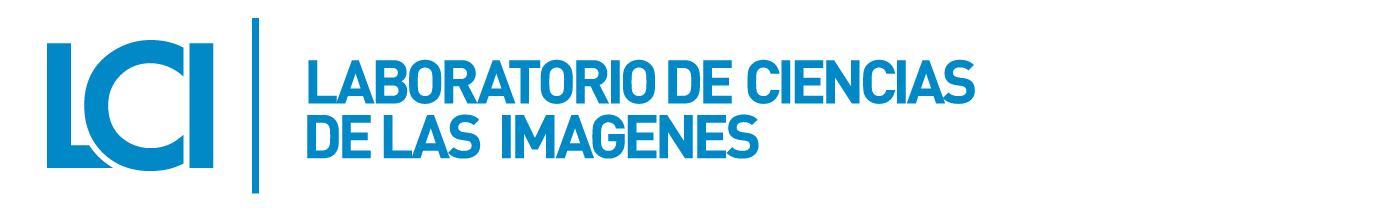

#**Universidad Nacional del Sur**
#Trabajo Final de Cátedra
##Tópicos Avanzados en Procesamiento de Imágenes
##Tema: Detección de neumonía bacteriana en pacientes pediátricos de 1 a 5 años aplicando una red neuronal convolucional

##Presentado por: Ronny Guevara
###Bahía Blanca - Argentina

## Resumen
En este trabajo se presenta la aplicación de redes neuronales convolucionales para identificar la neumonía en pacientes pediátricos de uno a cinco años del Centro Médico de Mujeres y Niños de Guangzho. Para ello, se utiliza un conjunto de datos de imágenes de rayos X de tórax (anterior-posterior) realizadas como parte de la atención clínica, posterior, todas las radiografías de tórax se revisaron inicialmente para el control de calidad mediante la eliminación de todos los escaneos de baja calidad o ilegibles y su diagnóstico fue calificado por 2 médicos expertos.

El conjunto de datos contiene 5232 imágenes de alta resolución con 3 canales de información (RGB), las mismas están divididas en 5016 imágenes para 'test', 200 imágenes para 'test' y 16 imágenes para 'val'.


## Objetivo General
Desarrollar un aplicativo que permita detectar neumonía en imágenes de rayos X implementando una red neuronal convolucional
## Objetivos Específicos
*   Desarrollar clasificadores que dado los atributos de un dataset permita predecir la benignidad o malignidad de un tumor
*   Mediante la selección de datos proponer un clasificador supervisados y entrenados
*   Visualización de resultados

###Introducción
La neumonía es un problema de salud que afecta a la población independientemente de su edad. Se calcula que la neumonía mata a unos 1,4 millones de niños menores de cinco años cada año, más que el SIDA, la malaria y el sarampión combinados, según la Organización Mundial de la Salud.
Es por esta razón que se ve la necesidad de crear un aplicativo que permita detectar casos de neumonía en niños de 1 a 5 años. 

Conozcamos algunas conceptualizaciones: 

*   Red Neuronal Convolucional: Las Redes neuronales convolucionales son  un tipo de redes neuronales artificiales  donde las «neuronas»  corresponden a campos receptivos de una manera muy similar a las neuronas en la corteza visual primaria (V1) de un cerebro biológico.  Este tipo de red es una variación de un perceptrón multicapa, sin embargo, debido a que su aplicación es realizada en matrices bidimensionales, son muy efectivas para tareas de visión artificial, como en la clasificación y segmentación de imágenes, entre otras aplicaciones.
*   Neumonía : La neumonía es un tipo de infección respiratoria aguda que afecta a los pulmones. Éstos están formados por pequeños sacos, llamados alvéolos, que en las personas sanas se llenan de aire al respirar. Los alvéolos de los enfermos de neumonía están llenos de pus y líquido, lo que hace dolorosa la respiración y limita la absorción de oxígeno.La neumonía es la principal causa individual de mortalidad infantil en todo el mundo. Se calcula que mata cada año a unos 1,4 millones de niños menores de cinco años, lo que supone el 18% de todas las defunciones de niños menores de cinco años en todo el mundo. 
Más información: https://www.paho.org/es/noticias/11-11-2011-neumonia-es-causa-principal-muerte-ninos#:~:text=Se%20calcula%20que%20la%20neumon%C3%ADa,Organizaci%C3%B3n%20Mundial%20de%20la%20Salud.

##Desarrollo
El desarrollo se divide en 2 etapas, la primera tiene como objetivo el desarrollo y entrenamiento de la red neuronal convolucional

###1. Desarrollo y entrenamiento de la red neuronal convolucional


In [1]:
#Lectura de librerías
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import io
import random

El conjunto de imágenes se encuentra cargado en el Drive por lo que es necesario hacer el respectivo llamado

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Asignamos la ruta de llamado para cada variable
normal_training_route = "/content/drive/MyDrive/Colab Notebooks/chest_xray/train/NORMAL"
pneumonia_training_route = "/content/drive/MyDrive/Colab Notebooks/chest_xray/train/PNEUMONIA"

###1.1. Creación de funciones

####1.1.1. Función image_processing
Las imágenes tienen el siguiente tratamiento: 

*   La imagen es leída mediante la librería CV2
*   Se aplica un filtro de conversión pasando del espacio RGB al espacio de escala de grises
*   Reajuste del tamaño de la imagen a 50 * 50 pixeles
*   Normalización de la imagen

In [4]:
def image_processing(image):
  tupla = []
  img_size = 50
  for img in os.listdir(image):
    img = cv2.imread(os.path.join(image, img))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_norm=img_gray.astype(np.float64)/255
    img_gray_resize = cv2.resize(img_norm,(img_size,img_size))
    tupla.append([img_gray_resize])
  return(tupla)

####1.1.2. Función image_info
Retorna información de la imagen:

*   Tipo de dato
*   Dimensiones

In [5]:
def image_info(image):
  normal = np.array(np.squeeze(image))
  print('This image is', normal.dtype)
  print('with dimensions', normal.shape)

####1.1.3. Función etiqueta
Retorna 2 tuplas cada una con el tamaño del total de imágenes para casos con y sin neumonía

In [6]:
def etiqueta(normal, neumonia):
  normal = normal.shape
  neumonia = neumonia.shape
  etiqueta = np.repeat((0, normal[0]))
  etiqueta1 = np.repeat((0, neumonia[0]))

  return(etiqueta, etiqueta1)

In [7]:
#Lectura de las imágenes de rayos X sin neumonía
normal = image_processing(normal_training_route)
image_info(normal)

This image is float64
with dimensions (1341, 50, 50)


In [8]:
#Lectura de las imágenes de rayos X con neumonía
neumonia = image_processing(pneumonia_training_route)
image_info(neumonia)

This image is float64
with dimensions (3875, 50, 50)


Debido a que las imágenes no se encuentran previamente etiquetadas, se crearan arreglos que contengan las etiquetas, siendo, 0 para casos sin neumonía y 1 para casos con neumonía

In [9]:
etiquetas_normal = np.repeat(0, 1341)
print(len(etiquetas_normal))
etiquetas_neumonia = np.repeat(1, 3875)
print(len(etiquetas_neumonia))

1341
3875


In [10]:
#Contiene el nombre para las etiquetas
class_names = ['Normal', 'Neumonia']

Proceso de concatenación de etiquetas e imágenes

In [11]:
rayos_x = np.squeeze(np.concatenate([normal,neumonia]))
rayos_x = np.array(rayos_x)
print(rayos_x.shape)
labels = np.concatenate([etiquetas_normal,etiquetas_neumonia])
labels = np.array(labels)

(5216, 50, 50)


Se da lectura (aleatoria) a 20 de las 5216 imágenes cada una con su respectiva etiqueta

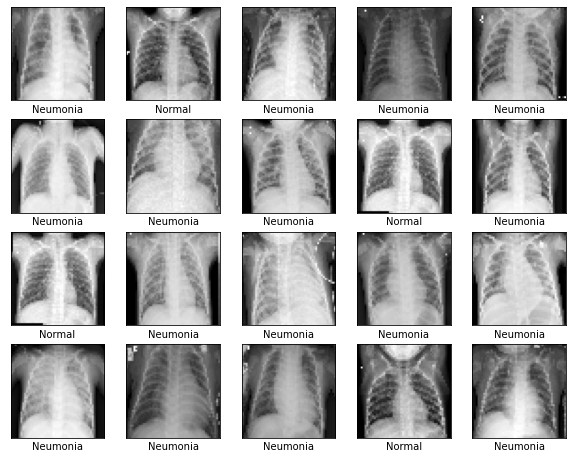

In [12]:
plt.figure(figsize=(10,10))
for i in range (20):
  j = random.randrange(5, 5216, 10)
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(np.squeeze(rayos_x[j]), cmap = 'gray')
  plt.xlabel(class_names[labels[j]])
plt.show()

###1.2. Diseño del modelo de red neuronal convolucional
Se probaron distintos modelos a diferente número de capas de convolución y capas densas, hasta obtener un modelo optimo tanto en características computacionales como en resultados de predicción.
Descripción del modelo: 


*   2 capas de convolución 
*   2 capas de agrupación máxima
*   1 capa de activación de neuronas 

In [13]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [14]:
#Porcentaje de entrenamiento
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(rayos_x, labels, test_size=200)
print('Son {} datos para entrenamiento y {} datos para prueba'.format(X_train.shape[0], X_test.shape[0]))

Son 5016 datos para entrenamiento y 200 datos para prueba


In [15]:
#Crear el modelo (Modelo denso, regular, sin redes convolucionales)
modelo = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(50,50,1)), 
    tf.keras.layers.Dense(units=50, activation='relu'),
    tf.keras.layers.Dense(units=50, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

#Compilar el modelo
modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

historial = modelo.fit(X_train, y_train, epochs=30)
pred = modelo.predict(X_test)

Epoch 1/30
157/157 [==============================] - 1s 5ms/step - loss: 0.3019 - accuracy: 0.8648
Epoch 2/30
157/157 [==============================] - 1s 5ms/step - loss: 0.1578 - accuracy: 0.9428
Epoch 3/30
157/157 [==============================] - 1s 5ms/step - loss: 0.1499 - accuracy: 0.9434
Epoch 4/30
157/157 [==============================] - 1s 5ms/step - loss: 0.1266 - accuracy: 0.9484
Epoch 5/30
157/157 [==============================] - 1s 5ms/step - loss: 0.1238 - accuracy: 0.9514
Epoch 6/30
157/157 [==============================] - 1s 4ms/step - loss: 0.1398 - accuracy: 0.9432
Epoch 7/30
157/157 [==============================] - 1s 4ms/step - loss: 0.1151 - accuracy: 0.9579
Epoch 8/30
157/157 [==============================] - 1s 4ms/step - loss: 0.1314 - accuracy: 0.9498
Epoch 9/30
157/157 [==============================] - 1s 4ms/step - loss: 0.1031 - accuracy: 0.9613
Epoch 10/30
157/157 [==============================] - 1s 5ms/step - loss: 0.1075 - accuracy: 0.9611

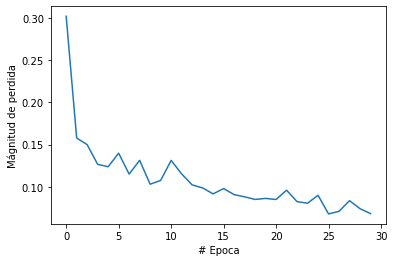

In [16]:
#Resultado de la red para cada vuelta
plt.xlabel('# Epoca')
plt.ylabel('Mágnitud de perdida')
plt.plot(historial.history['loss'])

Si bien, un modelo denso, regular sin capas de convolución llega a tener una precisión del 97%, si la imagen a evaluar sufre una alteración en sus ejes, el modelo no predice de manera asertiva

In [17]:
#Crear un modelo denso, convolucional
modelo_conv = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(50, 50, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(2, activation="softmax")
])

#Compilar el modelo
modelo_conv.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

historial = modelo_conv.fit(X_train, y_train, epochs=75)
pred_2=modelo_conv.predict(X_test)

Epoch 1/75
157/157 [==============================] - 18s 109ms/step - loss: 0.2693 - accuracy: 0.8904
Epoch 2/75
157/157 [==============================] - 17s 108ms/step - loss: 0.1281 - accuracy: 0.9496
Epoch 3/75
157/157 [==============================] - 17s 108ms/step - loss: 0.1155 - accuracy: 0.9589
Epoch 4/75
157/157 [==============================] - 17s 108ms/step - loss: 0.0918 - accuracy: 0.9649
Epoch 5/75
157/157 [==============================] - 17s 108ms/step - loss: 0.0920 - accuracy: 0.9655
Epoch 6/75
157/157 [==============================] - 17s 109ms/step - loss: 0.0825 - accuracy: 0.9701
Epoch 7/75
157/157 [==============================] - 17s 108ms/step - loss: 0.0771 - accuracy: 0.9725
Epoch 8/75
157/157 [==============================] - 17s 108ms/step - loss: 0.0694 - accuracy: 0.9743
Epoch 9/75
157/157 [==============================] - 17s 108ms/step - loss: 0.0662 - accuracy: 0.9747
Epoch 10/75
157/157 [==============================] - 17s 108ms/step - l

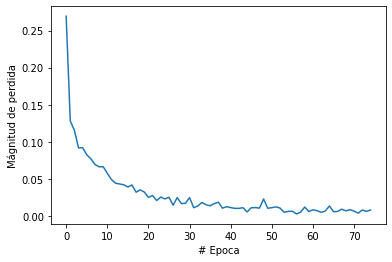

In [18]:
#Resultado de la red para cada vuelta
plt.xlabel('# Epoca')
plt.ylabel('Mágnitud de perdida')
plt.plot(historial.history['loss'])

El modelo convolucional se entrena de tal forma que si la imagen a evaluar sufrió alguna alteración en sus ejes o cambio de tamaño del tórax, este predice de manera correcta.

###5. Validación
Entrenado el modelo, lo podremos a prueba haciendo uso de un conjunto de datos conformado por 16 imágenes de rayos X de tórax de pacientes pediátricos(neumonía/normal)

In [19]:
#Asignamos la ruta de llamado para cada variable
dataset_val = "/content/drive/MyDrive/Colab Notebooks/chest_xray/val/NORMAL"

In [20]:
#Tratamiento de las imagenes
dataset_val = image_processing(dataset_val)
image_info(dataset_val)
dataset_val = np.squeeze(dataset_val)
dataset_val = np.array(dataset_val)

This image is float64
with dimensions (16, 50, 50)


Hagamos una prediccion
El resultado es[[0.11026471 0.88973534]]
1.0
El resultado es Neumonia


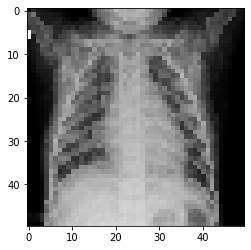

In [21]:
#@title Seleccione la imagen a evaluar { run: "auto" }
val_int = 12 #@param {type:"slider", min:1, max:16, step:1}
img = dataset_val[val_int]
plt.imshow(np.squeeze(img), cmap = 'gray')
img = (np.expand_dims(img, 0))
print('Hagamos una prediccion')
resultado = modelo.predict(img)
print('El resultado es'+ str(resultado))
print(np.sum(resultado))
print("El resultado es "  + str(class_names[np.argmax(resultado)]))


##Análisis de resultados

*   Se desarrolla una aplicativo que satisface con el objetivo del proyecto final de catedra, para predecir si el infante presenta neumonía o no se evalúa las características de la imagen de rayos X del tórax, se diseña y se entrena una red neuronal convolucional  de 6 capas (2 capas de convolución, 2 capas de agrupación máxima, 1 capa de activación y 1 capa de salida) obteniendo una precisión mayor al 99% y una perdida menor al 0.0100

*   La red neuronal convolucional fue evaluada con diferentes cantidades de capas y distintos parámetros, hasta obtener un modelo de alta precisión y optimizado computacionalmente. El número de veces de ejecución del algoritmo será de 75, dado que es el intervalo donde la perdida se mantiene estable.

*   La interactividad de la aplicación permite al usuario seleccionar del dataset ‘val’, una imagen aleatoriamente para determinar si la misma pertenece a un caso con neumonía.


